In [0]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %% [markdown]
# ## Import necessary dependencies


In [1]:
#!pip uninstall tensorflow -y
#!pip uninstall keras -y
#!pip install keras==2.1.6 
#!pip install tensorflow-gpu==1.15  # GPU

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2

from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import sqlite3
import re

import nltk
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence
import pydot

pd.options.display.max_colwidth = 200
%matplotlib inline

import tensorflow as tf
tf.test.gpu_device_name()


Uninstalling tensorflow-2.2.0rc2:
  Successfully uninstalled tensorflow-2.2.0rc2
Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 348kB 8.4MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
     |████████████████████████████████| 411.5MB 43kB/s 
     |████████████████████████████████| 3.8MB 43.9MB/s 
     |████████████████████████████████| 512kB 52.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=68dc36c313805e70ec12ea758f2df7e9e0f888abb66a53ac45bca9b591ac266c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensor

Using TensorFlow backend.


'/device:GPU:0'

In [0]:
#%% md

 ## Read in the data

In [0]:
#DIR='./CSML-1010/CSML1010-Project/data'

dbconn = sqlite3.connect('./newsclassifier.db')
train_data_df = pd.read_sql_query('SELECT * FROM train_data_sample', dbconn)
headline_bagofwords_df = pd.read_sql_query('SELECT * FROM headline_bagofwords', dbconn)
dbconn.commit()
dbconn.close()

In [4]:
# %%
# Define a clean function: lowercase, strip HTML, punctuations, non-alpha, stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
def clean(x):
    # strip HTML and sources of the format eg. "&lt and (Reuters)"
    x = re.sub(r'(&[A-Za-z]+)|\(.*\)', '', x)
    # split into words
    tokens = word_tokenize(x)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # # remove punctuation from each word
    # table = str.maketrans(string.punctuation, ' ')
    # stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # re-create document from words
    doc = ' '.join(words)
    return str(doc)

# %%
for i, row in train_data_df.iterrows():
    train_data_df.at[i, "headline_cleaned"] = clean(row.headline)
train_data_df.head()

,index,category,headline,content,headline_cleaned,content_cleaned
0,30870,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The National Hockey League locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by man...",nhl ice maybe whole season,"AP - No shots, no saves, no goals. The locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by management to gain massiv..."
1,7738,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.,rowers punished criticism teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.
2,25351,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in...",changing directions,"Over at -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in sports."""
3,74309,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...,cassini snapshots murky moon titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...
4,88347,1,Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to...",farewell yasser arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to..."


In [0]:
train_data_df.to_csv('./traindatacleaned.csv')

 ### Check the if the data was loaded correctly

In [89]:
train_data_df.head()



,category,headline,content,headline_cleaned,content_cleaned
0,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The National Hockey League locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by man...",nhl ice maybe whole season,"AP - No shots, no saves, no goals. The locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by management to gain massiv..."
1,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.,rowers punished criticism teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.
2,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in...",changing directions,"Over at -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in sports."""
3,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...,cassini snapshots murky moon titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...
4,1,Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to...",farewell yasser arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to..."


In [10]:
headline_bagofwords_df.head()



,index,abuse,acc,accept,add,adds,afghan,afp,africa,african,agree,agrees,ahead,aid,aim,aims,air,airlines,airways,al,alert,alive,allows,amd,american,amid,amp,anderson,anti,aol,ap,appoints,approach,arafat,argentine,arm,arms,army,arrested,arrests,...,want,wants,war,warm,warner,warning,warns,water,way,web,week,west,white,williams,win,windows,winning,wins,winter,wireless,woes,women,won,woods,woos,work,workers,world,wound,wrap,xp,yahoo,yankees,year,years,yen,yields,yukos,zero,zurich
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
train_data_df.drop('index', axis=1, inplace=True)
train_data_df.head()



,category,headline,content,headline_cleaned,content_cleaned
0,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The National Hockey League locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by man...","NHL on Ice, Maybe for Whole 2004-05 Season","AP - No shots, no saves, no goals. The locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by management to gain massiv..."
1,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.
2,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in...",Changing Directions,"Over at -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in sports."""
3,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...
4,1,Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to...",Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to..."


In [12]:
headline_bagofwords_df.drop('index', axis=1, inplace=True)
headline_bagofwords_df.head()



,abuse,acc,accept,add,adds,afghan,afp,africa,african,agree,agrees,ahead,aid,aim,aims,air,airlines,airways,al,alert,alive,allows,amd,american,amid,amp,anderson,anti,aol,ap,appoints,approach,arafat,argentine,arm,arms,army,arrested,arrests,asia,...,want,wants,war,warm,warner,warning,warns,water,way,web,week,west,white,williams,win,windows,winning,wins,winter,wireless,woes,women,won,woods,woos,work,workers,world,wound,wrap,xp,yahoo,yankees,year,years,yen,yields,yukos,zero,zurich
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


 ### We have bag of words already, let's make a Bag of N-Grams

In [0]:
# Use countvectorizer to get a word vector
cv = CountVectorizer(min_df = 2, lowercase = True, token_pattern=r'(?u)\b[A-Za-z]{2,}\b', 
                        strip_accents = 'ascii', ngram_range = (2, 3), 
                        stop_words = 'english')
cv_matrix = cv.fit_transform(train_data_df.headline_cleaned).toarray()

# below is if wanted to define a specific category for the data.
# cv_matrix = cv.fit_transform(train_data_df[train_data_df.category == 1].headline_cleaned).toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

# produce a dataframe including the feature names
headline_bagofngrams_df = pd.DataFrame(cv_matrix, columns=vocab)


 ### Make sure we got the dataframe output for the Bag of N-Grams

In [15]:
headline_bagofngrams_df.head()


,al qaeda,allows settler,allows settler homes,anti piracy,audit finds,bird flu,blast kills,blow icann,blow icann suit,bomber kills,china open,cut jobs,dealt legal,dealt legal blow,european shares,files bankruptcy,gaza raid,getty images,homes west,homes west bank,iaea report,icann suit,identity crisis,india pakistan,iraqi police,kill wound,kills palestinians,legal blow,legal blow icann,looming identity,looming identity crisis,lower profit,meteor shower,money green,moon titan,morgan stanley,mount st,mount st helens,nba wrap,new england,...,ole miss,open lower,open source,profit percent,profit taking,quarter profit,quarterly profit,quota hike,retail sales,ryder cup,schering plough,school siege,search engine,set open,settler homes,settler homes west,share buyback,sharon allows,sharon allows settler,st helens,start season,stock falls,stocks open,stocks open lower,stocks seen,stocks set,stocks set open,suicide bomber,suicide bomber kills,time warner,title hopes,tokyo stocks,verisign dealt,verisign dealt legal,version windows,west bank,win china,win china open,windows xp,world cup
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


 ### Let's explore the data we got through plots and tables

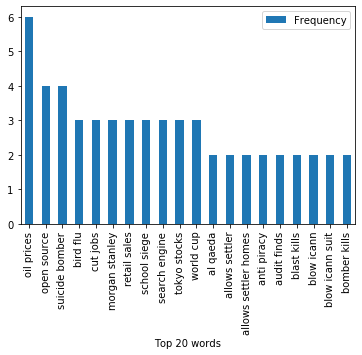

In [0]:
word_count_dict = {}
for word in vocab:
    word_count_dict[word] = int(sum(headline_bagofngrams_df.loc[:, word]))

counter = Counter(word_count_dict)

freq_df = pandas.DataFrame.from_records(counter.most_common(20),
                                        columns=['Top 20 words', 'Frequency'])
freq_df.plot(kind='bar', x='Top 20 words');



 ## TF/IDF

 ### Unigram TF/IDF

In [17]:
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, lowercase = True, 
                             strip_accents = 'ascii', ngram_range = (1, 1), 
                             stop_words = 'english', use_idf = True, token_pattern=r'(?u)\b[A-Za-z]{2,}\b')
tfidf_unigram = tfidf_vect.fit_transform(train_data_df.headline_cleaned).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_unigram = pd.DataFrame(np.round(tfidf_unigram, 2), columns = vocab)
tfidf_unigram.head()


,abuse,acc,accept,add,adds,afghan,africa,african,agree,agrees,ahead,aid,aim,aims,air,airlines,airways,al,alert,alive,allows,amd,american,amid,amp,anderson,anti,aol,appoints,approach,arafat,argentine,arm,arms,army,arrested,arrests,asia,astros,attack,...,want,wants,war,warm,warner,warning,warns,water,way,web,week,west,white,williams,win,windows,winning,wins,winter,wireless,woes,women,won,woods,woos,work,workers,world,wound,wrap,xp,yahoo,yankees,year,years,yen,yields,yukos,zero,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### N-Gram TF/IDF

In [18]:
tfidf_vect = TfidfVectorizer(sublinear_tf = True, min_df = 2, lowercase = True, 
                             strip_accents = 'ascii', ngram_range = (2, 3), 
                             stop_words = 'english', use_idf = True, token_pattern=r'(?u)\b[A-Za-z]{2,}\b')
tfidf_ngram = tfidf_vect.fit_transform(train_data_df.headline_cleaned).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_ngram = pd.DataFrame(np.round(tfidf_ngram, 2), columns = vocab)
tfidf_ngram.head()


,al qaeda,allows settler,allows settler homes,anti piracy,audit finds,bird flu,blast kills,blow icann,blow icann suit,bomber kills,china open,cut jobs,dealt legal,dealt legal blow,european shares,files bankruptcy,gaza raid,getty images,homes west,homes west bank,iaea report,icann suit,identity crisis,india pakistan,iraqi police,kill wound,kills palestinians,legal blow,legal blow icann,looming identity,looming identity crisis,lower profit,meteor shower,money green,moon titan,morgan stanley,mount st,mount st helens,nba wrap,new england,...,ole miss,open lower,open source,profit percent,profit taking,quarter profit,quarterly profit,quota hike,retail sales,ryder cup,schering plough,school siege,search engine,set open,settler homes,settler homes west,share buyback,sharon allows,sharon allows settler,st helens,start season,stock falls,stocks open,stocks open lower,stocks seen,stocks set,stocks set open,suicide bomber,suicide bomber kills,time warner,title hopes,tokyo stocks,verisign dealt,verisign dealt legal,version windows,west bank,win china,win china open,windows xp,world cup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


 ### Character TF/IDF

In [19]:
tfidf_vect = TfidfVectorizer(analyzer = 'char', sublinear_tf = True, min_df = 2, 
                             lowercase = True, strip_accents = 'ascii', ngram_range = (2, 3), 
                             stop_words = 'english', use_idf = True, token_pattern=r'\w{1,}')
tfidf_char = tfidf_vect.fit_transform(train_data_df.headline_cleaned).toarray()

# get all unique words in the corpus
vocab = tfidf_vect.get_feature_names()

tfidf_char = pd.DataFrame(np.round(tfidf_char, 2), columns = vocab)
tfidf_char.head()


,#,#3,','0,'a,'d,'g,'t,-,-,--,1,1,"1,",1.,10,11,12,13,14,18,19,2,2,2-,20,23,24,26,3,3,3-,30,34,35,3g,3q,4,4,40,...,yo,yof,yon,you,yp,ype,ypt,yr,yri,ys,ys,yst,yu,yuk,yuz,yw,ywa,z,z t,"z,","z,",za,za,zai,zar,ze,ze,zer,zi,zil,zl,zli,zo,zon,zu,zue,zur,zy,zz,zzl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.0,0.0,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


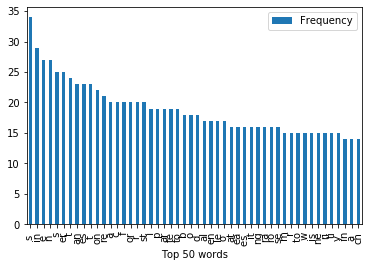

In [0]:
word_count_dict = {}
for word in vocab:
    word_count_dict[word] = int(sum(tfidf_char.loc[:, word]))

counter = Counter(word_count_dict)

freq_df = pandas.DataFrame.from_records(counter.most_common(50),
                                        columns=['Top 50 words', 'Frequency'])
freq_df.plot(kind='bar', x='Top 50 words');


 ## Word Embedding
 Build the Corpus Vocabulary

In [0]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(train_data_df.headline_cleaned)
word2id = tokenizer.word_index

# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in train_data_df.headline_cleaned]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:100])


Vocabulary Size: 3170
Vocabulary Sample: [('to', 1), ('in', 2), ('for', 3), ('39', 4), ('on', 5), ('of', 6), ('the', 7), ('s', 8), ('a', 9), ('up', 10), ('b', 11), ('at', 12), ('new', 13), ('with', 14), ('us', 15), ('and', 16), ('says', 17), ('as', 18), ('by', 19), ('is', 20), ('oil', 21), ('1', 22), ('more', 23), ('china', 24), ('u', 25), ('no', 26), ('profit', 27), ('stocks', 28), ('iraq', 29), ('back', 30), ('win', 31), ('out', 32), ('report', 33), ('from', 34), ('ibm', 35), ('microsoft', 36), ('over', 37), ('open', 38), ('will', 39), ('it', 40), ('deal', 41), ('be', 42), ('sales', 43), ('bid', 44), ('world', 45), ('bush', 46), ('plans', 47), ('not', 48), ('off', 49), ('2', 50), ('quot', 51), ('cup', 52), ('prices', 53), ('india', 54), ('gets', 55), ('calls', 56), ('un', 57), ('kills', 58), ('buy', 59), ('can', 60), ('t', 61), ('get', 62), ('oracle', 63), ('000', 64), ('against', 65), ('fall', 66), ('iraqi', 67), ('plan', 68), ('are', 69), ('3', 70), ('may', 71), ('season', 72), ('a

In [0]:
# Build a CBOW (context, target) generator
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[numpy.argwhere(y[0])[0][0]])
    
        if i == 20:
            break
        i += 1


Context (X): ['nhl', 'on', 'maybe', 'for'] -> Target (Y): ice
Context (X): ['on', 'ice', 'for', 'whole'] -> Target (Y): maybe
Context (X): ['ice', 'maybe', 'whole', '2004'] -> Target (Y): for
Context (X): ['maybe', 'for', '2004', '05'] -> Target (Y): whole
Context (X): ['for', 'whole', '05', 'season'] -> Target (Y): 2004
Context (X): ['rowers', 'to', 'punished', 'for'] -> Target (Y): be
Context (X): ['to', 'be', 'for', 'criticism'] -> Target (Y): punished
Context (X): ['be', 'punished', 'criticism', 'of'] -> Target (Y): for
Context (X): ['punished', 'for', 'of', 'teammate'] -> Target (Y): criticism
Context (X): ['cassini', 'snapshots', 'moon', 'titan'] -> Target (Y): murky
Context (X): ['english', 'players', 'media', 'after'] -> Target (Y): snub
Context (X): ['players', 'snub', 'after', 'victory'] -> Target (Y): media
Context (X): ['explosives', 'were', 'after', 'iraq'] -> Target (Y): looted
Context (X): ['were', 'looted', 'iraq', 'invasion'] -> Target (Y): after
Context (X): ['mine', 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 4, 100)            317000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3170)              320170    
Total params: 637,170
Trainable params: 637,170
Non-trainable params: 0
_________________________________________________________________
None


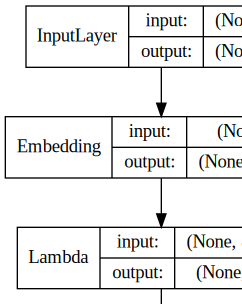

In [0]:

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

# Build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

# visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg'))


In [0]:
# %% [markdown]
# ## Using gensim to build Word2Vec

In [0]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in train_data_df.headline_cleaned]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 20          # Context window size      
workers = 10                                                                              
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=500)
#w2v_model
# view similar words based on gensim's model
#similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
#                  for search_term in ['god', 'jesus', 'noah', 'egypt', #'john', 'gospel', 'moses','famine']}
#similar_words

In [0]:
# %% [markdown]
# ## Visualize Word Embedding

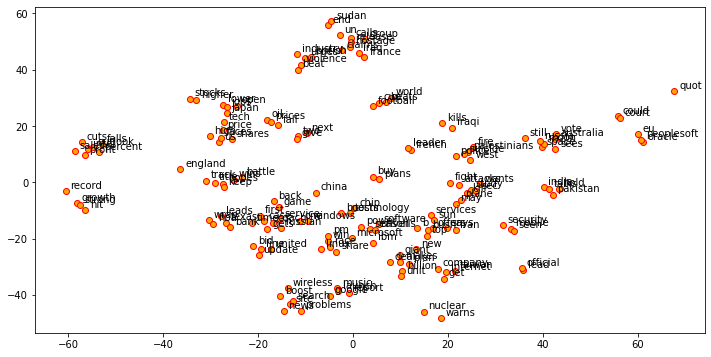

In [38]:
from sklearn.manifold import TSNE
words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=500, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words
plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
 plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')


In [18]:
#w2v_model.wv['sales']

array([-0.29738706,  0.35484955, -0.1252585 , -0.02680124, -0.4717425 ,
       -0.30456853,  0.29737353,  0.05397404, -0.60855216,  0.10550004,
       -0.1561834 , -0.2576906 ,  0.18851258,  0.18605322, -0.05243433,
        0.10304447,  0.6872783 ,  0.30120423,  0.12156212,  0.2056017 ,
        0.1956256 ,  0.07334057, -0.07225127,  0.47113147,  0.18745412,
        0.11502072, -0.0460945 ,  0.02054803, -0.3928173 ,  0.16137841,
        0.08244079,  0.18346044, -0.23969306,  0.4685089 , -0.04071501,
        0.62442636,  0.02569026, -0.35967916, -0.07480519, -0.00234481,
       -0.32182372, -0.5985934 , -0.30845648,  0.01650351, -0.10929374,
       -0.12275068, -0.6578349 , -0.07105249, -0.3632399 ,  0.49017212,
       -0.3048464 ,  0.34995553, -0.34519112,  0.06494297, -0.2123074 ,
       -0.08588416, -0.5346264 ,  0.5021928 , -0.11173971, -0.606097  ,
        0.46237868, -0.14027496,  0.00321802,  0.35656774, -0.4966246 ,
        0.26975435,  0.40705612, -0.25457674,  0.04835572, -0.34

In [0]:
# %% [markdown]
# ## Functions to get document level embeddings
# ### The idea is to distill a word vector of 'n' features into a single point and use that at a document level
def average_word_vectors(words, model, vocabulary, num_features):

 feature_vector = np.zeros((num_features,),dtype="float64")
 nwords = 0.

 for word in words:
    if word in vocabulary:
      nwords = nwords + 1.
      feature_vector = np.add(feature_vector, model[word])

 if nwords:
    feature_vector = np.divide(feature_vector, nwords)

 return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
 vocabulary = set(model.wv.index2word)
 features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
            for tokenized_sentence in corpus]
 return np.array(features)

In [39]:
# %% [markdown]
# ## Obtain document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                            num_features=feature_size)
pd.DataFrame(w2v_feature_array)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.255275,0.402535,-0.043731,0.285416,0.090367,-0.179401,0.059238,0.103594,0.044203,-0.269141,-0.102308,-0.339016,0.248841,0.030961,-0.128796,0.406263,-0.061173,-0.089063,-0.043098,-0.067306,-0.045999,-0.393541,0.044966,0.394824,-0.022769,-0.133715,-0.029688,-0.158299,-0.085578,-0.112070,0.056845,0.097179,-0.203641,0.281416,0.462930,-0.090578,-0.030885,0.153781,-0.104412,-0.212110,...,0.258835,0.020675,-0.268155,-0.476405,-0.178798,0.009132,0.099047,0.205426,0.039890,-0.007475,-0.022929,0.166229,-0.357552,0.048596,0.176328,-0.159887,0.022459,-0.224964,-0.126411,-0.012377,0.508629,0.119244,0.067580,-0.291040,0.035321,0.120883,0.274243,0.037048,0.013845,-0.377837,0.165112,0.141167,-0.085987,0.077986,0.165879,-0.088049,0.083068,0.351606,-0.240596,-0.125024
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,-0.081183,0.244545,0.050210,0.263389,0.369754,-0.176841,-0.105048,-0.020515,0.287066,-0.318558,-0.556428,-0.519517,0.587554,-0.143529,0.096432,0.087977,0.018499,-0.328490,-0.180488,0.727015,-0.130108,0.011240,-0.078384,0.561259,-0.124942,0.259924,-0.586961,-0.145856,-0.126743,0.579434,0.011308,-0.158374,0.016595,0.751689,-0.052605,-0.243243,-0.137186,0.023044,-0.385782,0.152789,...,0.190313,0.505520,0.008733,-0.375992,-0.053011,0.171621,-0.045869,0.391575,-0.068093,0.144017,-0.250438,0.257266,-0.222952,0.427068,0.363812,-0.098806,-0.543135,-0.090969,0.090552,-0.044167,0.207047,0.008908,-0.382413,-0.770542,0.072793,0.198677,0.104694,-0.141876,0.257041,-0.406892,-0.011408,-0.364189,-0.119616,-0.043238,0.514138,-0.207968,-0.161272,0.231934,-0.458032,-0.693872
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,

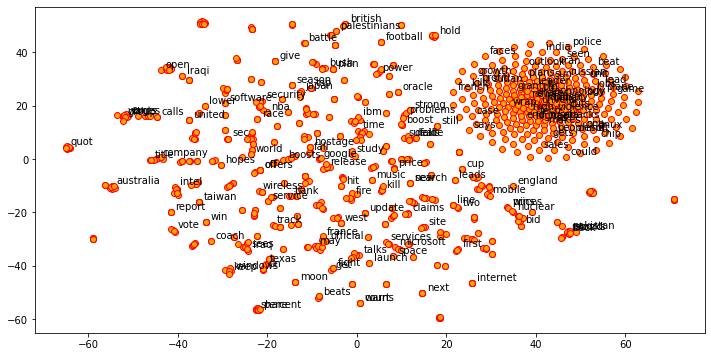

In [42]:
from sklearn.manifold import TSNE
#words = w2v_model.wv.index2word
wvs1 = w2v_feature_array
tsne = TSNE(n_components=2, random_state=0, n_iter=500, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs1)
labels = words
plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
 plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

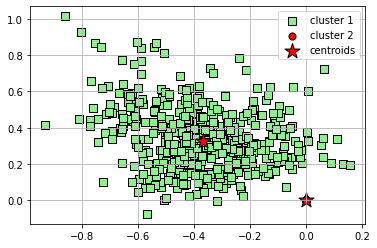

In [49]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(w2v_feature_array)

# plot the 3 clusters
plt.scatter(
    w2v_feature_array[y_km == 0, 0], w2v_feature_array[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    w2v_feature_array[y_km == 1, 0], w2v_feature_array[y_km == 1, 1],
    s=50, c='red',
    marker='o', edgecolor='black',
    label='cluster 2'
)

#plt.scatter(
#    w2v_feature_array[y_km == 2, 0], w2v_feature_array[y_km == 2, 1],
#    s=50, c='lightblue',
#    marker='v', edgecolor='black',
#    label='cluster 3'
#)

#plt.scatter(
#    w2v_feature_array[y_km == 2, 0], w2v_feature_array[y_km == 2, 1],
#    s=50, c='red',
#    marker='h', edgecolor='black',
#    label='cluster 4'
#)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [27]:
# %% [markdown]
# ## Clustering with document embeddings

#from sklearn.cluster import AffinityPropagation
ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([train_data_df, cluster_labels], axis=1)


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


,index,category,headline,content,headline_cleaned,content_cleaned,ClusterLabel
0,30870,2,"NHL on Ice, Maybe for Whole 2004-05 Season (AP)","AP - No shots, no saves, no goals. The National Hockey League locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by man...",nhl ice maybe whole season,"AP - No shots, no saves, no goals. The locked out its players, threatening to keep the sport off the ice for the entire 2004-05 season and perhaps beyond in an effort by management to gain massiv...",-1
1,7738,2,Rowers to be punished for criticism of teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.,rowers punished criticism teammate,ROWER Sally Robbins #39;s teammates are expected to face disciplinary action for publicly criticising her failure to complete the women #39;s eight final.,-1
2,25351,2,Changing Directions,"Over at USA Today -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in...",changing directions,"Over at -- Slogan: ""All the News That's Fit to Print in Four Paragraphs or Less"" -- they got together the last couple of weeks and asked the staff to vote for the ""10 things to change in sports.""",-1
3,74309,4,Cassini snapshots murky moon Titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...,cassini snapshots murky moon titan,The Cassini probe got the first close-up photos of Saturn #39;s murky moon Titan on Tuesday and began sending them back to Earth. This image is one of the closest ever taken of Saturn #39;s hazy m...,-1
4,88347,1,Farewell Yasser Arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to...",farewell yasser arafat,"GAZA CITY, 12 November 2004 - The world will bid farewell to Abu Ammar, Yasser Arafat, as one of the towering figures of Arab politics embarks on his final journey with a state funeral in Cairo to...",-1
...,...,...,...,...,...,...,...
995,9253,1,"Typhoon Aere Pounds Taiwan, Heads Into China (Reuters)",Reuters - A powerful typhoon triggered landslides\and flash floods in northern Taiwan on Wednesday before plowing\into China where hundreds of thousands of people have been\evacuated.,typhoon aere pounds taiwan heads china,Reuters - A powerful typhoon triggered landslides\and flash floods in northern Taiwan on Wednesday before plowing\into China where hundreds of thousands of people have been\evacuated.,-1
996,256,4,"""Unusually Good"" Meteor Shower Expected Tonight","Tonight's annual Perseid meteor shower is likely to be a spectacular show of shooting stars zipping across the night sky, according to astronomers.",unusually good meteor shower expected tonight,"Tonight's annual Perseid meteor shower is likely to be a spectacular show of shooting stars zipping across the night sky, according to astronomers.",-1
997,103054,2,A Lot to Play for in Skins Game Finale,"Annika Sorenstam calmly sank a short birdie putt on the ninth hole, earning a hug from Tiger Woods. More importantly, it kept \$250,000 in play in the Skins Game in La Quinta, Calif.",lot play skins game finale,"Annika Sorenstam calmly sank a short birdie putt on the ninth hole, earning a hug from Tiger Woods. More importantly, it kept \$250,000 in play in the Skins Game in La Quinta, Calif.",-1
998,81702,4,Mars Rovers Get Mystery Power Boost,"As NASA (news - web sites) #39;s Mars rovers keep rolling past all expectations of their useful lives, scientists have a happy mystery: For some reason one",mars rovers get mystery power boost,"A